In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


PROMPT_EMBED SHAPES: prompt_embeds: torch.Size([1, 154, 4096]), pooled_prompt_embeds: torch.Size([1, 2048])


  0%|          | 0/28 [00:00<?, ?it/s]

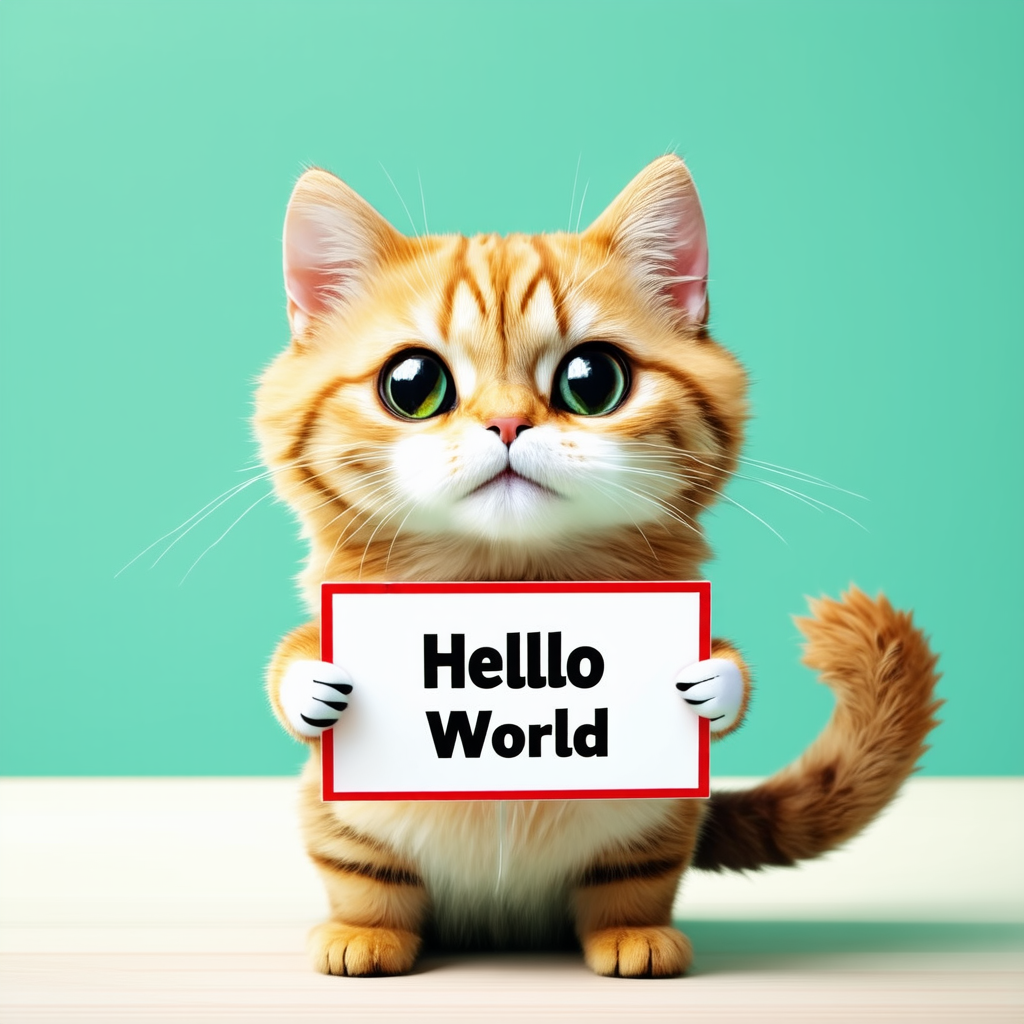

In [2]:
import torch
from stable_diffusion3 import StableDiffusion3Pipeline, retrieve_timesteps

pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3-medium-diffusers", torch_dtype=torch.float16)
pipe.text_encoder_3 = None
pipe = pipe.to("cuda")

image = pipe(
    "A cat holding a sign that says hello world",
    negative_prompt="",
    num_inference_steps=28,
    guidance_scale=7.0,
    height=1024,
    width=1024,
).images[0]
image

In [7]:
import numpy as np
import matplotlib.pyplot as plt
image_pt = torch.tensor(np.array(image), device='cuda').half().permute(2, 0, 1)[None] / 127.5 - 1
out = pipe.vae.encode(image_pt).latent_dist.sample()
latent = (out - pipe.vae.config.shift_factor) * pipe.vae.config.scaling_factor

pipe.scheduler.set_timesteps(1000)
index = torch.randint(0, 1000, size=(1,))
index = torch.zeros_like(index) + 500
with torch.no_grad():
    v_pred, v_target = pipe.train_step(latent, "A cat holding a sign that says hello world", index)

index, ((v_pred - v_target) ** 2).mean()

PROMPT_EMBED SHAPES: prompt_embeds: torch.Size([1, 154, 4096]), pooled_prompt_embeds: torch.Size([1, 2048])


(tensor([500]), tensor(0.6953, device='cuda:0', dtype=torch.float16))

In [3]:
from diffusion.utils.misc import read_config
from diffusion.data.buildea import build_dataset, build_dataloader
from diffusion.utils.data_sampler import AspectRatioBatchSampler
from torch.utils.data import RandomSampler

config_path='/mnt/bn/us-aigc-temp/henry/mm-diffusion-pixart/configs/zjl_test/textart_ud_sg.py'
config = read_config(config_path)

/home/tiger/.local/lib/python3.9/site-packages/bytedmetrics/__init__.py:10: UserWarning: bytedmetrics is renamed to bytedance.metrics, please using `bytedance.metrics` instead of `bytedmetrics`
  warnings.warn("bytedmetrics is renamed to bytedance.metrics, please using `bytedance.metrics` instead of `bytedmetrics`")
/home/tiger/.local/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [4]:
data_config = {
    'type': 'FlexibleInternalDataMS',
    'roots': ['/mnt/bn/us-aigc-temp/henry/coco_2014/val/val2014/'],
    'json_lst': ['/mnt/bn/us-aigc-temp/henry/test.json'],
    'load_vae_feat': False,
    'load_t5_feat': False
}
dataset = build_dataset(
    data_config, resolution=512, aspect_ratio_type='ASPECT_RATIO_512',
    real_prompt_ratio=0.0, max_length=77,
)
batch_sampler = AspectRatioBatchSampler(sampler=RandomSampler(dataset), dataset=dataset,
                                    batch_size=50, aspect_ratios=dataset.aspect_ratio, drop_last=True,
                                    ratio_nums=dataset.ratio_nums, config=config, valid_num=config.valid_num)
dataloader = build_dataloader(dataset, batch_sampler=batch_sampler, num_workers=config.num_workers)

2024-07-22 07:16:53,613 - PixArt - INFO - Constructing dataset FlexibleInternalDataMS...
2024-07-22 07:16:53,614 - PixArt - INFO - T5 max token length: 77
2024-07-22 07:16:53,615 - PixArt - INFO - ratio of real user prompt: 0.0
2024-07-22 07:16:53,676 - PixArt - INFO - /mnt/bn/us-aigc-temp/henry/test.json data volume: 5000
2024-07-22 07:16:53,696 - PixArt - INFO - Dataset FlexibleInternalDataMS constructed. time: 0.08 s, length (use/ori): 5000/5000
2024-07-22 07:16:53,697 - PixArt - WARNING - Using valid_num=0 in config file. Available 40 aspect_ratios: ['0.25', '0.26', '0.27', '0.28', '0.32', '0.33', '0.35', '0.4', '0.42', '0.48', '0.5', '0.52', '0.57', '0.6', '0.68', '0.72', '0.78', '0.82', '0.88', '0.94', '1.0', '1.07', '1.13', '1.21', '1.29', '1.38', '1.46', '1.67', '1.75', '2.0', '2.09', '2.4', '2.5', '2.89', '3.0', '3.11', '3.62', '3.75', '3.88', '4.0']


In [75]:
# pipe.scheduler.set_timesteps(1000)
# pipe.scheduler.timesteps
pipe.scheduler.begin_index
def scale_noise(scheduler, sample, index, noise):
    sigma = scheduler.sigmas[index].to(sample.device)
    print(index, sigma)
    noisy_sample = sigma * noise + (1.0 - sigma) * sample
    return noisy_sample

In [29]:
print(latent.min(), latent.max())
noise = torch.randn_like(latent)
index = torch.randint(0, 1000, size=(1,))
noisy_latent = scale_noise(pipe.scheduler, latent, index, noise)


NameError: name 'latent' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.55102015..1.6384808].


tensor(-1., device='cuda:0') tensor(1., device='cuda:0')
tensor([825]) tensor([0.3916], device='cuda:0')


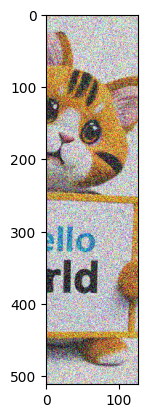

In [77]:
print(image_pt.min(), image_pt.max())
noise = torch.randn_like(image_pt)
index = torch.randint(0, 1000, size=(1,))
noisy_sample = scale_noise(pipe.scheduler, image_pt, index, noise)
plt.imshow(noisy_sample[0].permute(1, 2, 0).detach().cpu() * .5 + .5)